In [6]:
from google.cloud import bigquery
import pandas as pd

In [7]:
project_id = 'tcc-puc-mg-2019'
train_percent=0.25
table_name='tcc-puc-mg-2019.book.natality'
col_names = '''
    is_male,child_race,weight_pounds,plurality,mother_race,
    mother_age,gestation_weeks,mother_married,cigarette_use,
    cigarettes_per_day,alcohol_use,drinks_per_week,weight_gain_pounds,
    born_alive_alive,born_alive_dead,ever_born,father_race,father_age,y
'''
col_names_array = [x.strip() for x in col_names.split(',')]
col_names_array

['is_male',
 'child_race',
 'weight_pounds',
 'plurality',
 'mother_race',
 'mother_age',
 'gestation_weeks',
 'mother_married',
 'cigarette_use',
 'cigarettes_per_day',
 'alcohol_use',
 'drinks_per_week',
 'weight_gain_pounds',
 'born_alive_alive',
 'born_alive_dead',
 'ever_born',
 'father_race',
 'father_age',
 'y']

In [8]:
client = bigquery.Client(project=project_id)

In [9]:
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = [ 
    bigquery.ScalarQueryParameter("train_percent", "FLOAT", train_percent)
]
df = client.query('''
    SELECT 
        SAFE_CAST(((COUNT(1) * @train_percent) / 2) AS INT64) AS train_size_0,
        SAFE_CAST(((COUNT(1) * @train_percent) / 2) AS INT64) AS train_size_1
    FROM 
        `''' + table_name + '''`
''',
location='US',
job_config=job_config
).to_dataframe()

train_size_0 = int(df.iloc[0]['train_size_0'])
train_size_1 = int(df.iloc[0]['train_size_1'])

train_size_0, train_size_1

(4633334, 4633334)

In [10]:
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = [ 
    bigquery.ScalarQueryParameter("train_size_0", "INT64", train_size_0),
    bigquery.ScalarQueryParameter("train_size_1", "INT64", train_size_1)
]

df = client.query('''
        SELECT *
        FROM (  SELECT ''' + col_names + ''' 
                FROM `''' + table_name + '''` 
                WHERE y = 0
                LIMIT @train_size_0 )
    UNION ALL
        SELECT *
        FROM (  SELECT ''' + col_names + ''' 
                FROM `''' + table_name + '''` 
                WHERE y = 1
                LIMIT @train_size_1 )
''',
location='US',
job_config=job_config
).to_dataframe()

df.dtypes

is_male                 int64
child_race              int64
weight_pounds         float64
plurality               int64
mother_race             int64
mother_age              int64
gestation_weeks         int64
mother_married          int64
cigarette_use           int64
cigarettes_per_day      int64
alcohol_use             int64
drinks_per_week         int64
weight_gain_pounds    float64
born_alive_alive        int64
born_alive_dead         int64
ever_born               int64
father_race             int64
father_age              int64
y                       int64
dtype: object

In [11]:
X = df[col_names_array[:-1]] # Features
y = df[col_names_array[-1]] # Target variable

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
col_names_array[-1]

'y'

In [12]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1145516,   12152],
       [   1586, 1157413]])

Text(0.5, 257.44, 'Predicted label')

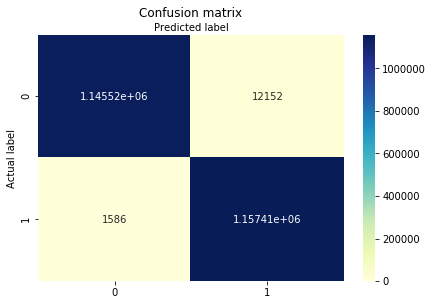

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9940699289108016
Precision: 0.9896098121951323
Recall: 0.9986315777666762


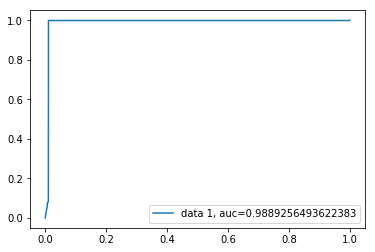

In [17]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##### 